# Sayera Dhaubhadel

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.integrate as integrate
import scipy.special as special
from scipy import fftpack as fft
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource


## Function that returns the albedo map and surface normals using corresponding light sources

In [25]:
'''
A function that takes a numpy array of images and source directions
    images: a 3D array of size (num_images, m, n)
    source_directions: the light source matrix of size (num_images, 3)
    
returns the albedo and normal
'''
def get_surface_normals_and_albedo(images, source_directions):
    I = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
    I = I / 255         #Intensity values replaced by their normalized (I/255) values 
    S = source_directions
    
    #using pseudo inverse to zero out any equations from shadow points
    g = np.dot(np.dot(np.linalg.pinv(np.dot(S.T, S)), S.T), I)
    
    albedo = np.sqrt(np.square(g[0]) + np.square(g[1]) + np.square(g[2])).reshape(images.shape[1], images.shape[2])
    
    n_0 = (g[0] / albedo.reshape(-1)).reshape(images.shape[1], images.shape[2])
    n_1 = (g[1] / albedo.reshape(-1)).reshape(images.shape[1], images.shape[2])
    n_2 = (g[2] / albedo.reshape(-1)).reshape(images.shape[1], images.shape[2])
    
    normals = np.array([n_0, n_1, n_2])
    
    return albedo, normals

## Function that returns the height map from the surface normals

In [44]:
#This is what I implemented based on the notes
#this looks ok as per the equation given
'''

'''
def get_heights1(normals):
    heights = np.zeros(normals[0].shape)
    print(heights.shape)
    p = -normals[0]/normals[2]
    q = -normals[1]/normals[2]
    
    for i, height in np.ndenumerate(heights):
        #heights[i] = integrate.cumtrapz(lambda x: q[0, x], x=np.arange(0, i[1]+1), axis=0, initial=0) + integrate.cumtrapz(lambda x: p[x, i[1]], x=np.arange(0, i[0]+1), axis=0, initial=0)
        left = np.sum([q[0, y] for y in range(0, i[1]+1)])
        right = np.sum([p[x, i[1]] for x in range(0, i[0]+1)])
        heights[i] = left + right
    return heights

In [45]:
#This is what I got online from https://github.com/JaggerWu/Photometric-Stereo/blob/master/processing/ps_utils.py
 """
    Integration of the normal field recovered from observations onto 
    a depth map via Simchony et al. hybrid DCT / finite difference
    methods.
    
    Done by solving via DCT a finite difference equation discretizing
    the equation:
        Laplacian(z) - Divergence((n1/n3, n2/n3)) = 0
    under proper boundary conditions ("natural" boundary conditions on 
    a rectangular domain)
    
    Arguments:
    ----------
    n1, n2, n3: nympy float arrays 
        the 3 components of the normal field. They must be 2D arrays
        of size (m,n). Array (function) n3 should never be 0.
       
    Returns:
    --------
        z : depth map obtained by integration of the field -n1/n3, -n2/n3
    """

def central_diff_x(p):
    x = p.shape[0]
    west = [0] + list(range(x-1))
    east = list(range(1, x)) + [x-1]
    return 0.5*(p[east, :] - p[west, :])

def central_diff_y(q):
    y = q.shape[1]
    south = [0] + list(range(y-1))
    north = list(range(1, y)) + [y-1]
    return 0.5*(q[:, north] - q[:, south])

def get_heights2(normals):
    m, n = normals[0].shape
   
    p = -normals[0]/normals[2]
    q = -normals[1]/normals[2]
    
    #Central differences for p and q   
    px = central_diff_x(p)
    qy = central_diff_y(q)
    
    f = px + qy
    
    #Four edges
    f[0, 1:-1]  = 0.5*(p[0, 1:-1] + p[1, 1:-1])    
    f[-1, 1:-1] = 0.5*(-p[-1, 1:-1] - p[-2, 1:-1])
    f[1:-1, 0]  = 0.5*(q[1:-1, 0] + q[1:-1, 1])
    f[1:-1, -1] = 0.5*(-q[1:-1, -1] - q[1:-1, -2])
    
    #four corners
    f[0, 0] = 0.5*(p[0, 0] + p[1, 0] + q[0, 0] + q[0, 1])
    f[-1, 0] = 0.5*(-p[-1, 0] - p[-2, 0] + q[-1, 0] + q[-1, 1])
    f[0, -1] = 0.5*(p[0, -1] + p[1, -1] - q[0, -1] - q[1, -1])
    f[-1, -1] = 0.5*(-p[-1, -1] - p[-2, -1] - q[-1, -1] - q[-1, -2])
    
    # cosine transform f
    fs = fft.dct(f, axis=0, norm='ortho')
    fs = fft.dct(fs, axis=1, norm='ortho')
    
    x, y = np.mgrid[0:m,0:n]
    denum = (2*np.cos(np.pi*x/m) - 2) + (2*np.cos(np.pi*y/n) -2)
    Z = fs/denum
    Z[0,0] = 0.0 
    
    
    z = fft.dct(Z, type=3, norm='ortho', axis=0)
    z = fft.dct(z, type=3, norm='ortho', axis=1)
    
    return z

## Open the images and create numpy arrays of images and source directions

In [29]:
image1 = np.array(Image.open("images/im1.png").convert("L"))
image2 = np.array(Image.open("images/im2.png").convert("L"))
image3 = np.array(Image.open("images/im3.png").convert("L"))
image4 = np.array(Image.open("images/im4.png").convert("L"))

synthetic_images = np.array([image1, image2, image3, image4])
synthetic_source_directions = np.array([[0, 0, -1], [0, 0.2, -1], [0, -0.2, -1], [0.2, 0, -1]])
# images.shape

real_image1 = np.array(Image.open("images/real1.bmp").convert("L"))
real_image2 = np.array(Image.open("images/real2.bmp").convert("L"))
real_image3 = np.array(Image.open("images/real3.bmp").convert("L"))
real_image4 = np.array(Image.open("images/real4.bmp").convert("L"))

real_images = np.array([real_image1, real_image2, real_image3, real_image4])
real_source_directions = np.array([[-0.38359, -0.236647, 0.892668], [-0.372825, 0.303914, 0.87672], [0.250814, 0.34752, 0.903505], [0.203844, -0.096308, 0.974255]])
# real_source_directions.shape



## Get the surface albedo and surface normals
## Then, plot the grayscale image showing albedo map of synthetic and real data

Albedo map for synthetic images from (46, 46) to (50, 50)
[[0.54580486 0.54935758 0.55208489 0.55764927 0.55973858]
 [0.55052276 0.55429499 0.55716376 0.559961   0.56491198]
 [0.55440134 0.55831265 0.56222867 0.56504619 0.5690709 ]
 [0.55729256 0.5626707  0.56640539 0.56896542 0.57422532]
 [0.56518226 0.56886818 0.57187899 0.57789606 0.57964276]]

x-components of surface normals for synthetic images from (46, 46) to (50, 50)
[[ 0.20357296  0.20225644  0.20125729  0.21096963  0.19850537]
 [ 0.13059483  0.12970607  0.12903823  0.10504933  0.12726837]
 [ 0.058946    0.05853304  0.04650028  0.03470131  0.05742648]
 [-0.01172804 -0.02323188 -0.03461804 -0.03446228 -0.0341466 ]
 [-0.10407887 -0.11489389 -0.114289   -0.13571882 -0.1127582 ]]

y-components of surface normals for synthetic images from (46, 46) to (50, 50)
[[ 0.23351016  0.16061541  0.08878998  0.         -0.0875759 ]
 [ 0.23150901  0.15918472  0.08798061  0.         -0.08677389]
 [ 0.22988938  0.15803922  0.08718803  0.        

Text(0.5,1,'Albedo of real data')

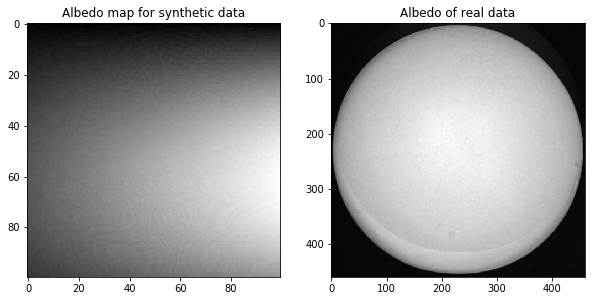

In [30]:
albedo_synthetic, normals_synthetic = get_surface_normals_and_albedo(synthetic_images, synthetic_source_directions)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(albedo_synthetic * 255 , cmap = plt.cm.gray)
plt.title("Albedo map for synthetic data")
print("Albedo map for synthetic images from (46, 46) to (50, 50)")
print(albedo_synthetic[46:51, 46:51])
print("\nx-components of surface normals for synthetic images from (46, 46) to (50, 50)")
print(normals_synthetic[0][46:51, 46:51])
print("\ny-components of surface normals for synthetic images from (46, 46) to (50, 50)")
print(normals_synthetic[1][46:51, 46:51])
print("\nz-components of surface normals for synthetic images from (46, 46) to (50, 50)")
print(normals_synthetic[2][46:51, 46:51])

albedo_real, normals_real = get_surface_normals_and_albedo(real_images, real_source_directions)
plt.subplot(1, 2, 2)
plt.imshow(albedo_real * 255, cmap = plt.cm.gray)
plt.title("Albedo of real data")
# print(albedo_real[46:51, 46:51])
# print(normals_real[0][46:51, 46:51])
# print(normals_real[1][46:51, 46:51])
# print(normals_real[2][46:51, 46:51])

## Get the depth (heights) of the real and synthetic data

In [54]:
heights_synthetic1 = get_heights1(normals_synthetic)
heights_synthetic2 = get_heights2(normals_synthetic)
print("Depth of synthetic images from (46, 46) to (50, 50) using function get_heights1")
print(heights_synthetic1[46:51, 46:51])
print("\nDepth of synthetic images from (46, 46) to (50, 50) using function get_heights2")
print(heights_synthetic2[46:51, 46:51])

heights_real1 = get_heights1(normals_real)
heights_real2 = get_heights2(normals_real)
print("\nDepth of real images from (46, 46) to (50, 50) using function get_heights1")
print(heights_real1[46:51, 46:51])
print("\nDepth of real images from (46, 46) to (50, 50) using function get_heights2")
print(heights_real2[46:51, 46:51])

(100, 100)


/Users/sayeradbl/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


Depth of synthetic images from (46, 46) to (50, 50) using function get_heights1
[[84.82706073 84.90774051 84.9354595  84.4545789  85.49310466]
 [84.96252871 85.04027064 85.06610083 84.5602127  85.62191028]
 [85.02320832 85.09965306 85.1128298  84.59493492 85.679647  ]
 [85.01116013 85.07612365 85.07810758 84.56045217 85.64540043]
 [84.90324646 84.95902763 84.96263414 84.42346586 85.53150521]]

Depth of synthetic images from (46, 46) to (50, 50) using function get_heights2
[[43.76485459 43.96441758 44.09088599 44.14313532 44.09716671]
 [43.9276284  44.13129368 44.26005388 44.30898954 44.2638412 ]
 [44.01912425 44.22210033 44.34748128 44.3894785  44.35020499]
 [44.03631046 44.23750662 44.35499549 44.39362007 44.35503457]
 [43.96553107 44.16518446 44.28041215 44.31969977 44.27432119]]
(460, 460)

Depth of real images from (46, 46) to (50, 50) using function get_heights1
[[-0.29781457 -0.35974376 -0.43024271 -0.66944644 -0.83768976]
 [-0.22552507 -0.27679104 -0.34728999 -0.56835458 -0.7365

## Three images showing three components of surface normal for synthetic data

Text(0.5,1,'z-component of normals of synthetic data')

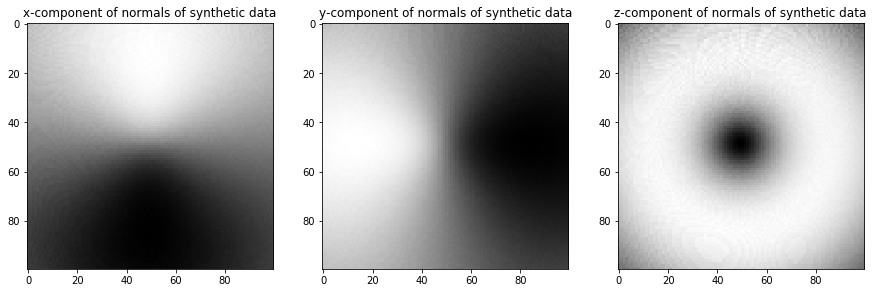

In [31]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(normals_synthetic[0] * 255, cmap = plt.cm.gray)
plt.title("x-component of normals of synthetic data")

plt.subplot(1, 3, 2)
plt.imshow(normals_synthetic[1] * 255, cmap = plt.cm.gray)
plt.title("y-component of normals of synthetic data")

plt.subplot(1, 3, 3)
plt.imshow(normals_synthetic[2] * 255, cmap = plt.cm.gray)
plt.title("z-component of normals of synthetic data")

## Three images showing three components of surface normal for real data

Text(0.5,1,'z-component of normals of real data')

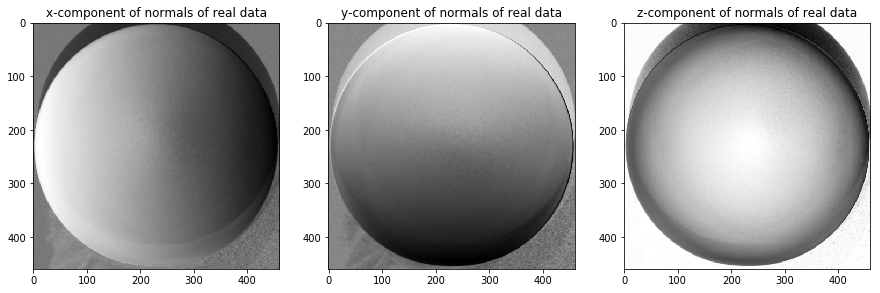

In [32]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(normals_real[0] * 255, cmap = plt.cm.gray)
plt.title("x-component of normals of real data")

plt.subplot(1, 3, 2)
plt.imshow(normals_real[1] * 255, cmap = plt.cm.gray)
plt.title("y-component of normals of real data")

plt.subplot(1, 3, 3)
plt.imshow(normals_real[2] * 255, cmap = plt.cm.gray)
plt.title("z-component of normals of real data")

## 3D surface plot for actual height values

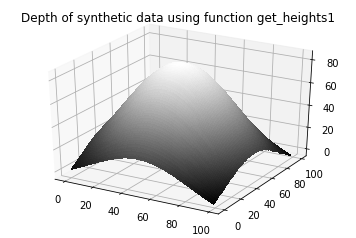

In [50]:
z = heights_synthetic1
m, n = z.shape
x, y = np.mgrid[0:m, 0:n]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap='gray', rstride=1, cstride=1, linewidth=0, antialiased=False)

plt.title('Depth of synthetic data using function get_heights1')
plt.show()

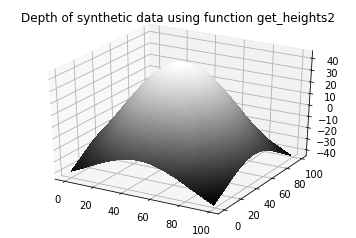

In [51]:
z = heights_synthetic2
m, n = z.shape
x, y = np.mgrid[0:m, 0:n]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, cmap='gray', rstride=1, cstride=1, linewidth=0, antialiased=False)

plt.title('Depth of synthetic data using function get_heights2')
plt.show()

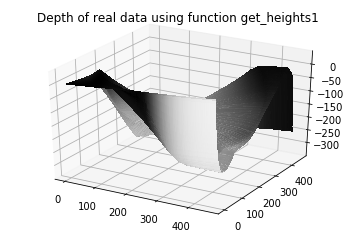

In [52]:
z = heights_real1
m, n = z.shape
x, y = np.mgrid[0:m, 0:n]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, rstride=1, cstride=1, linewidth=0, antialiased=False, facecolors=greyvals)

plt.title('Depth of real data using function get_heights1')
plt.show()

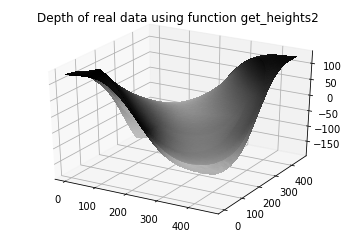

In [53]:
z = heights_real2
m, n = z.shape
x, y = np.mgrid[0:m, 0:n]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, rstride=1, cstride=1, linewidth=0, antialiased=False, facecolors=greyvals)

plt.title('Depth of real data using function get_heights2')
plt.show()

## 2D Images of estimated height map

Text(0.5,1,'2-D Image for depth of real data using function get_heights1')

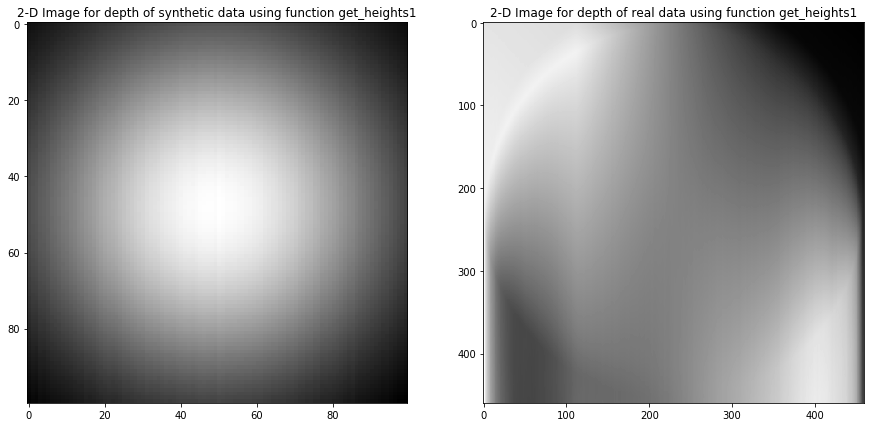

In [57]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(heights_synthetic1 * 255, cmap = plt.cm.gray)
plt.title("2-D Image for depth of synthetic data using function get_heights1")

plt.subplot(1, 2, 2)
plt.imshow(heights_real1 * 255, cmap = plt.cm.gray)
plt.title("2-D Image for depth of real data using function get_heights1")

Text(0.5,1,'2-D Image for depth of real data using function get_heights1')

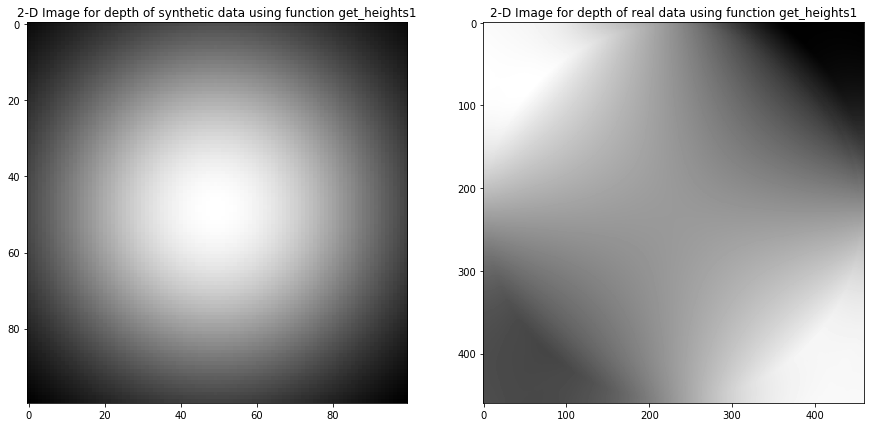

In [58]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(heights_synthetic2 * 255, cmap = plt.cm.gray)
plt.title("2-D Image for depth of synthetic data using function get_heights1")

plt.subplot(1, 2, 2)
plt.imshow(heights_real2 * 255, cmap = plt.cm.gray)
plt.title("2-D Image for depth of real data using function get_heights1")